#DATA 620 Project 2
**Team 2:** Christophe Hunt, Joel Park, Ilya Kats, Pavan Akula, Nathan (Seoungyoon) Lim

###Project Description

The goal of the project is to create and analyze a two-node social network for sponsorship of bill and interests group affiliation within the U.S. Senate. Any mention of *bills* below implies *bills and resolutions*. Bills can be introduced by several senators, but only one, whose name appears first on the bill, is considered its sponsor. Senator may sponsor a bill for various reasons - because they support it, because they want to have a record of supporting it, because their constituents request it, and even to show support for bill's sponsor. Sometimes Senator may sponsor a bill to get campaign contributions to get elected to public office. Companies, labor unions, and other organizations spend billions of dollars each year on lobbying Congress and federal agencies. Before a bill is drafted Senator's staff, lobbyists and special interests groups work together tirelessly. Each bill is classified into a *subject* based on its *legislative* purpose. We will be analyzing the relationship between *Senators* and *Subjects* they are interested in. This type of social network is known as *affiliation* or *bipartite* networks.

###Specific project requirements:

- Identify a large two-node network dataset. Data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
- Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
- What can you infer about each of the distinct groups?

###We will be extracting following information from the data

- Senators presenting most bills
- Subjects on which most bills are presented.

###Data Source

For the project, we are analyzing affiliation between sponsors and subjects of bills within the U.S. Senate of the 114th Congress that met from January 3, 2015, to January 3, 2017. The official repository of the U.S. legislative data is Congress.gov. The bills data is also maintained by the U.S. Government Publishing Office. The data for the 114th Congress is available at https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/. The data is stored in XML format and contains a significant amount of metadata to describe a bill and its activity in Congress.

The public @unitedstates project maintains data and tools to access and analyze the governmental data including congressional data. Our primary data source is archived bills data from the 114th Congress prepared by the Sunlight Foundation. The data is saved in JSON format. Data access and format description is available at https://github.com/unitedstates/congress/wiki.

###Data Import

After downloading bills information from https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/, we have extracted required data and saved it to MySQL relational database on Google Cloud.

In [1]:
#Libraries used
import numpy as np
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite

In [2]:
#Retrieve data from cloud database
sql_con = pymysql.connect(host='104.196.212.179', port=3306, user='root', passwd='data620pw', db='billsdata')

query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject as `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid ) a "
        "GROUP BY senator, `subject`;")

subjectInfo = pd.read_sql(query, con=sql_con)

#Small subset of data
query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject AS `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid "
        "WHERE s.`name` IN ('Harry Reid','Elizabeth Warren', 'Mitch McConnell','Jeff Sessions','Bernard Sanders') ) a "
        "GROUP BY senator, `subject`")

smallSubset = pd.read_sql(query, con=sql_con)

sql_con.close()

#Seperate data into senators and billsubject
senatorsList = subjectInfo.senator.unique()
subjectList = subjectInfo.subject.unique()

senatorsList = senatorsList.tolist()
subjectList = subjectList.tolist()

#Small subset
subSetsenatorsList = smallSubset.senator.unique()
subSetsubjectList = smallSubset.subject.unique()

subSetsenatorsList = subSetsenatorsList.tolist()
subSetsubjectList = subSetsubjectList.tolist()

###Classification of bills sponsored by Senator based on subject.

In [3]:
#Weight shows number of bills presented on a subject by Senator
subjectInfo.sort_values(['weight'], ascending = False, inplace=True)
subjectInfo

senator                              subject  weight
710        Lisa Murkowski                               Energy      30
887        Orrin G. Hatch                             Taxation      23
204        Chuck Grassley                               Health      21
716        Lisa Murkowski   Public lands and natural resources      17
290          David Vitter                               Health      17
638            Jon Tester   Armed forces and national security      15
107          Bill Cassidy                               Health      15
645            Jon Tester                     Native Americans      14
280          David Vitter                             Commerce      13
1135        Sherrod Brown                               Health      13
859           Mike Rounds   Armed forces and national security      13
1090            Ron Wyden   Public lands and natural resources      13
199        Chuck Grassley            Crime and law enforcement      13
359      Edward J. Markey                               Energy      13
1093            Ron Wyden                             Taxation      12
761      Mark Steven Kirk   Armed forces and national security      12
465        Jeanne Shaheen   Armed forces and national security      12
626            John Thune                             Taxation      12
523           Jerry Moran   Armed forces and national security      11
769      Mark Steven Kirk                               Health      11
562         John Barrasso                     Native Americans      11
151    Charles E. Schumer            Crime and law enforcement      11
1050  Robert P. Jr. Casey                               Health      11
301           Dean Heller   Armed forces and national security      11
83     Benjamin L. Cardin                International affairs      11
1073          Ron Johnson   Government operations and politics      11
5              Al Franken                               Health      11
957    Richard Blumenthal   Armed forces and national security      10
872        Orrin G. Hatch            Crime and law enforcement      10
728           Marco Rubio                International affairs      10
...                   ...                                  ...     ...
623            John Thune                     Native Americans       1
629        Johnny Isakson         Economics and public finance       1
630        Johnny Isakson   Government operations and politics       1
572          John Boozman                               Energy       1
570          John Boozman              Arts, culture, religion       1
568          John Boozman                 Agriculture and food       1
546          Joe Donnelly                 Labor and employment       1
531           Jerry Moran                                  Law       1
533           Jerry Moran   Public lands and natural resources       1
534           Jerry Moran  Science, technology, communications       1
537           Jerry Moran          Water resources development       1
539          Joe Donnelly            Crime and law enforcement       1
540          Joe Donnelly                            Education       1
541          Joe Donnelly             Environmental protection       1
543          Joe Donnelly   Government operations and politics       1
544          Joe Donnelly                               Health       1
545          Joe Donnelly    Housing and community development       1
547          Joe Donnelly      Transportation and public works       1
566         John Barrasso      Transportation and public works       1
548       Joe Manchin III   Armed forces and national security       1
549       Joe Manchin III         Economics and public finance       1
551       Joe Manchin III         Finance and financial sector       1
552       Joe Manchin III   Government operations and politics       1
554       Joe Manchin III                 Labor and employment       1
555       Joe Manchin III   Public lands a

Lisa Murkowski is the Chairman of Committee on Energy and Natural Resources. Orrin G. Hatch is the Chairman of Committee on Finance.

###Two-mode Network Graph

Following graph shows two sets of nodes and relationships between sets. The first set of nodes are Senators and second set is a bill subject. Sets of nodes are related, but there is no relation between each set of nodes. This shows there is no connection between Senators. We can also notice there is no link between bill subjects.

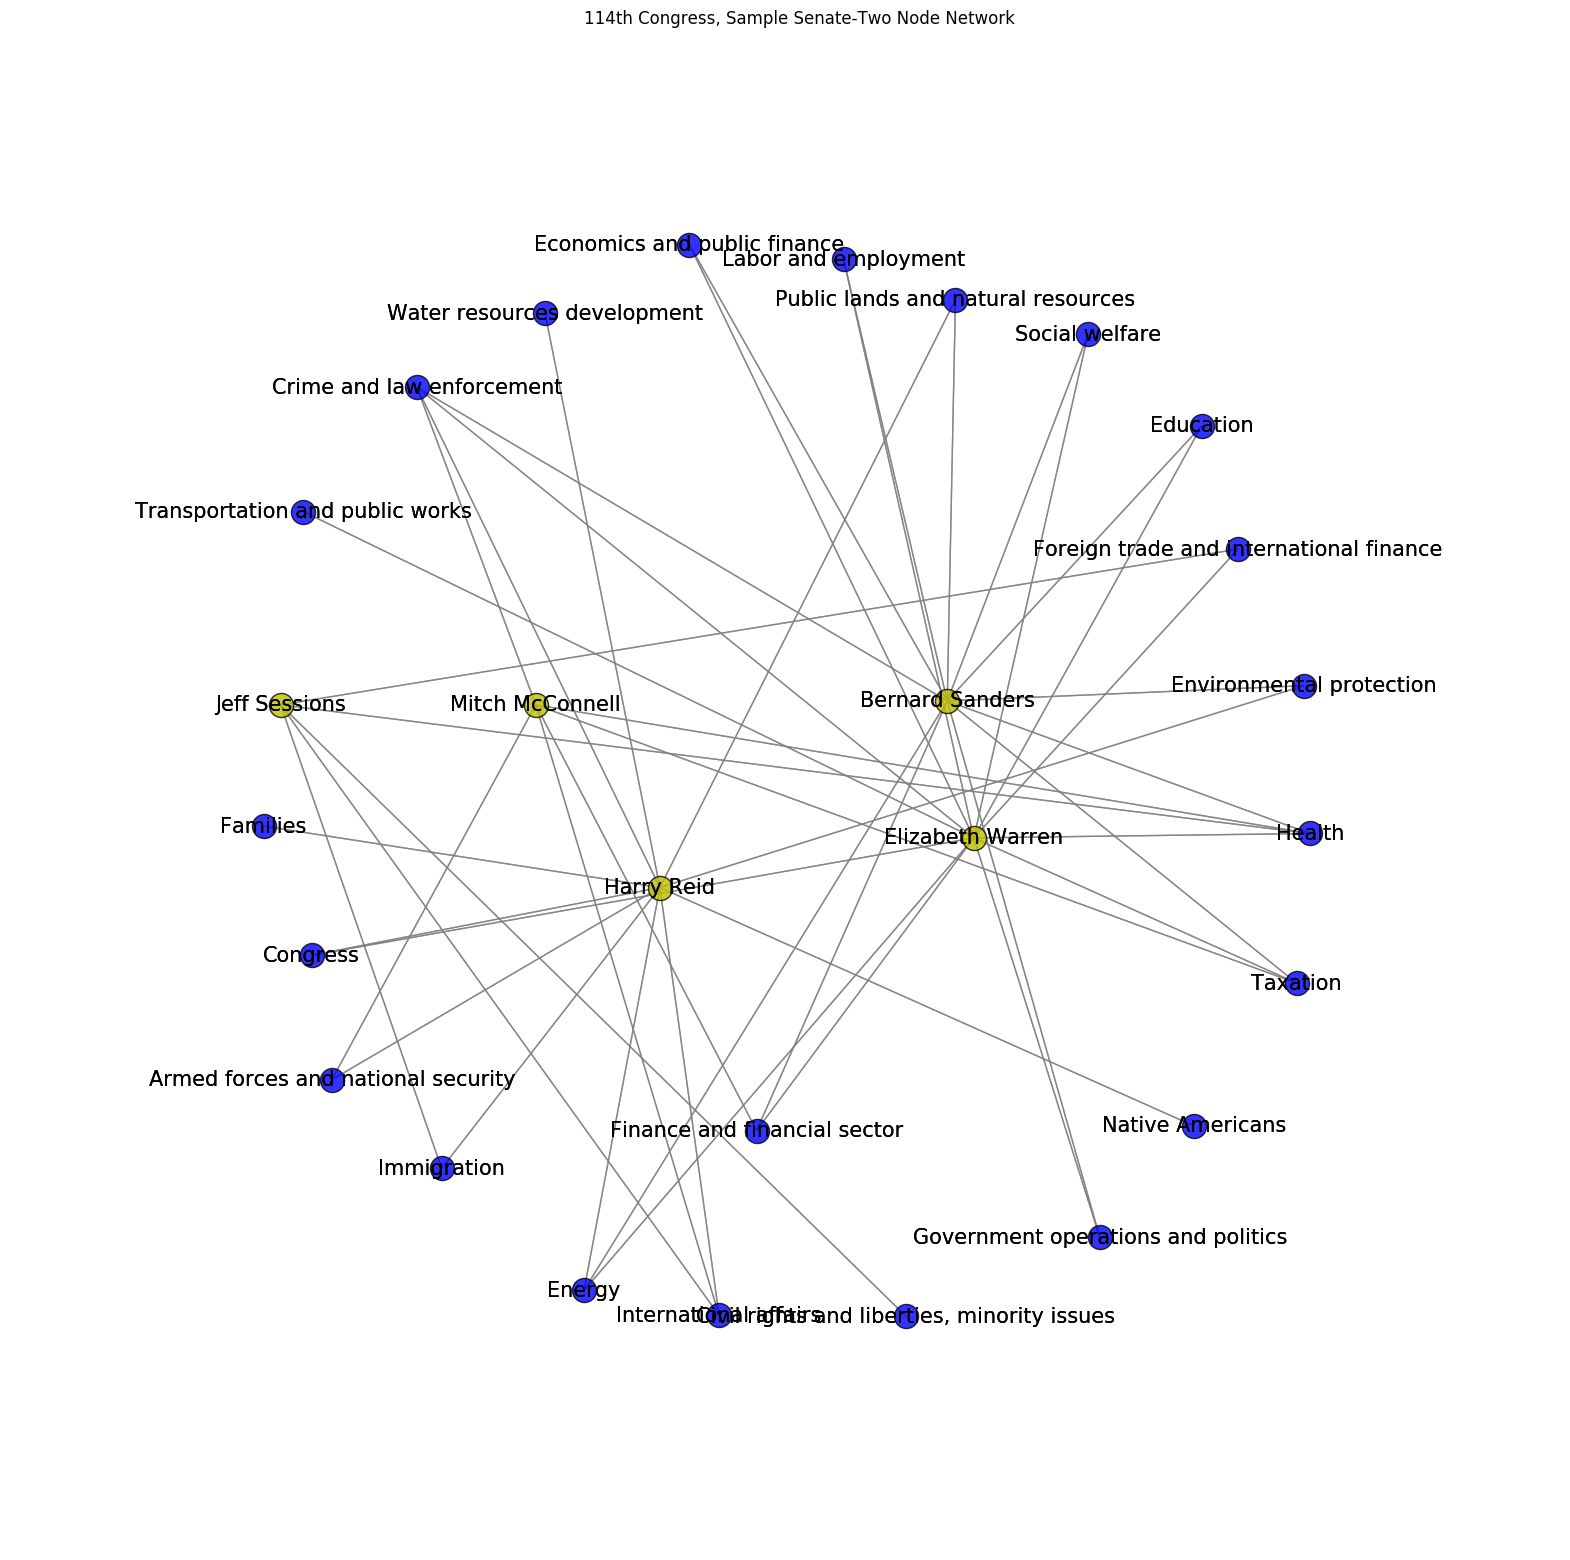

In [4]:
#Small subset data to show two-mode graph
%matplotlib inline

fig = plt.figure(figsize=(15, 15))
B = nx.Graph()
B.add_nodes_from(subSetsenatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subSetsubjectList, bipartite=1)

for index, row in smallSubset.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.5, iterations=25)
nx.draw(B, nodelist = subSetsenatorsList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(B, nodelist = subSetsubjectList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('114th Congress, Sample Senate-Two Node Network')
plt.show()

Following is an entire two-mode graph showing a relationship between Senators and bill subjects. We will be working with the whole dataset for the rest of the project.

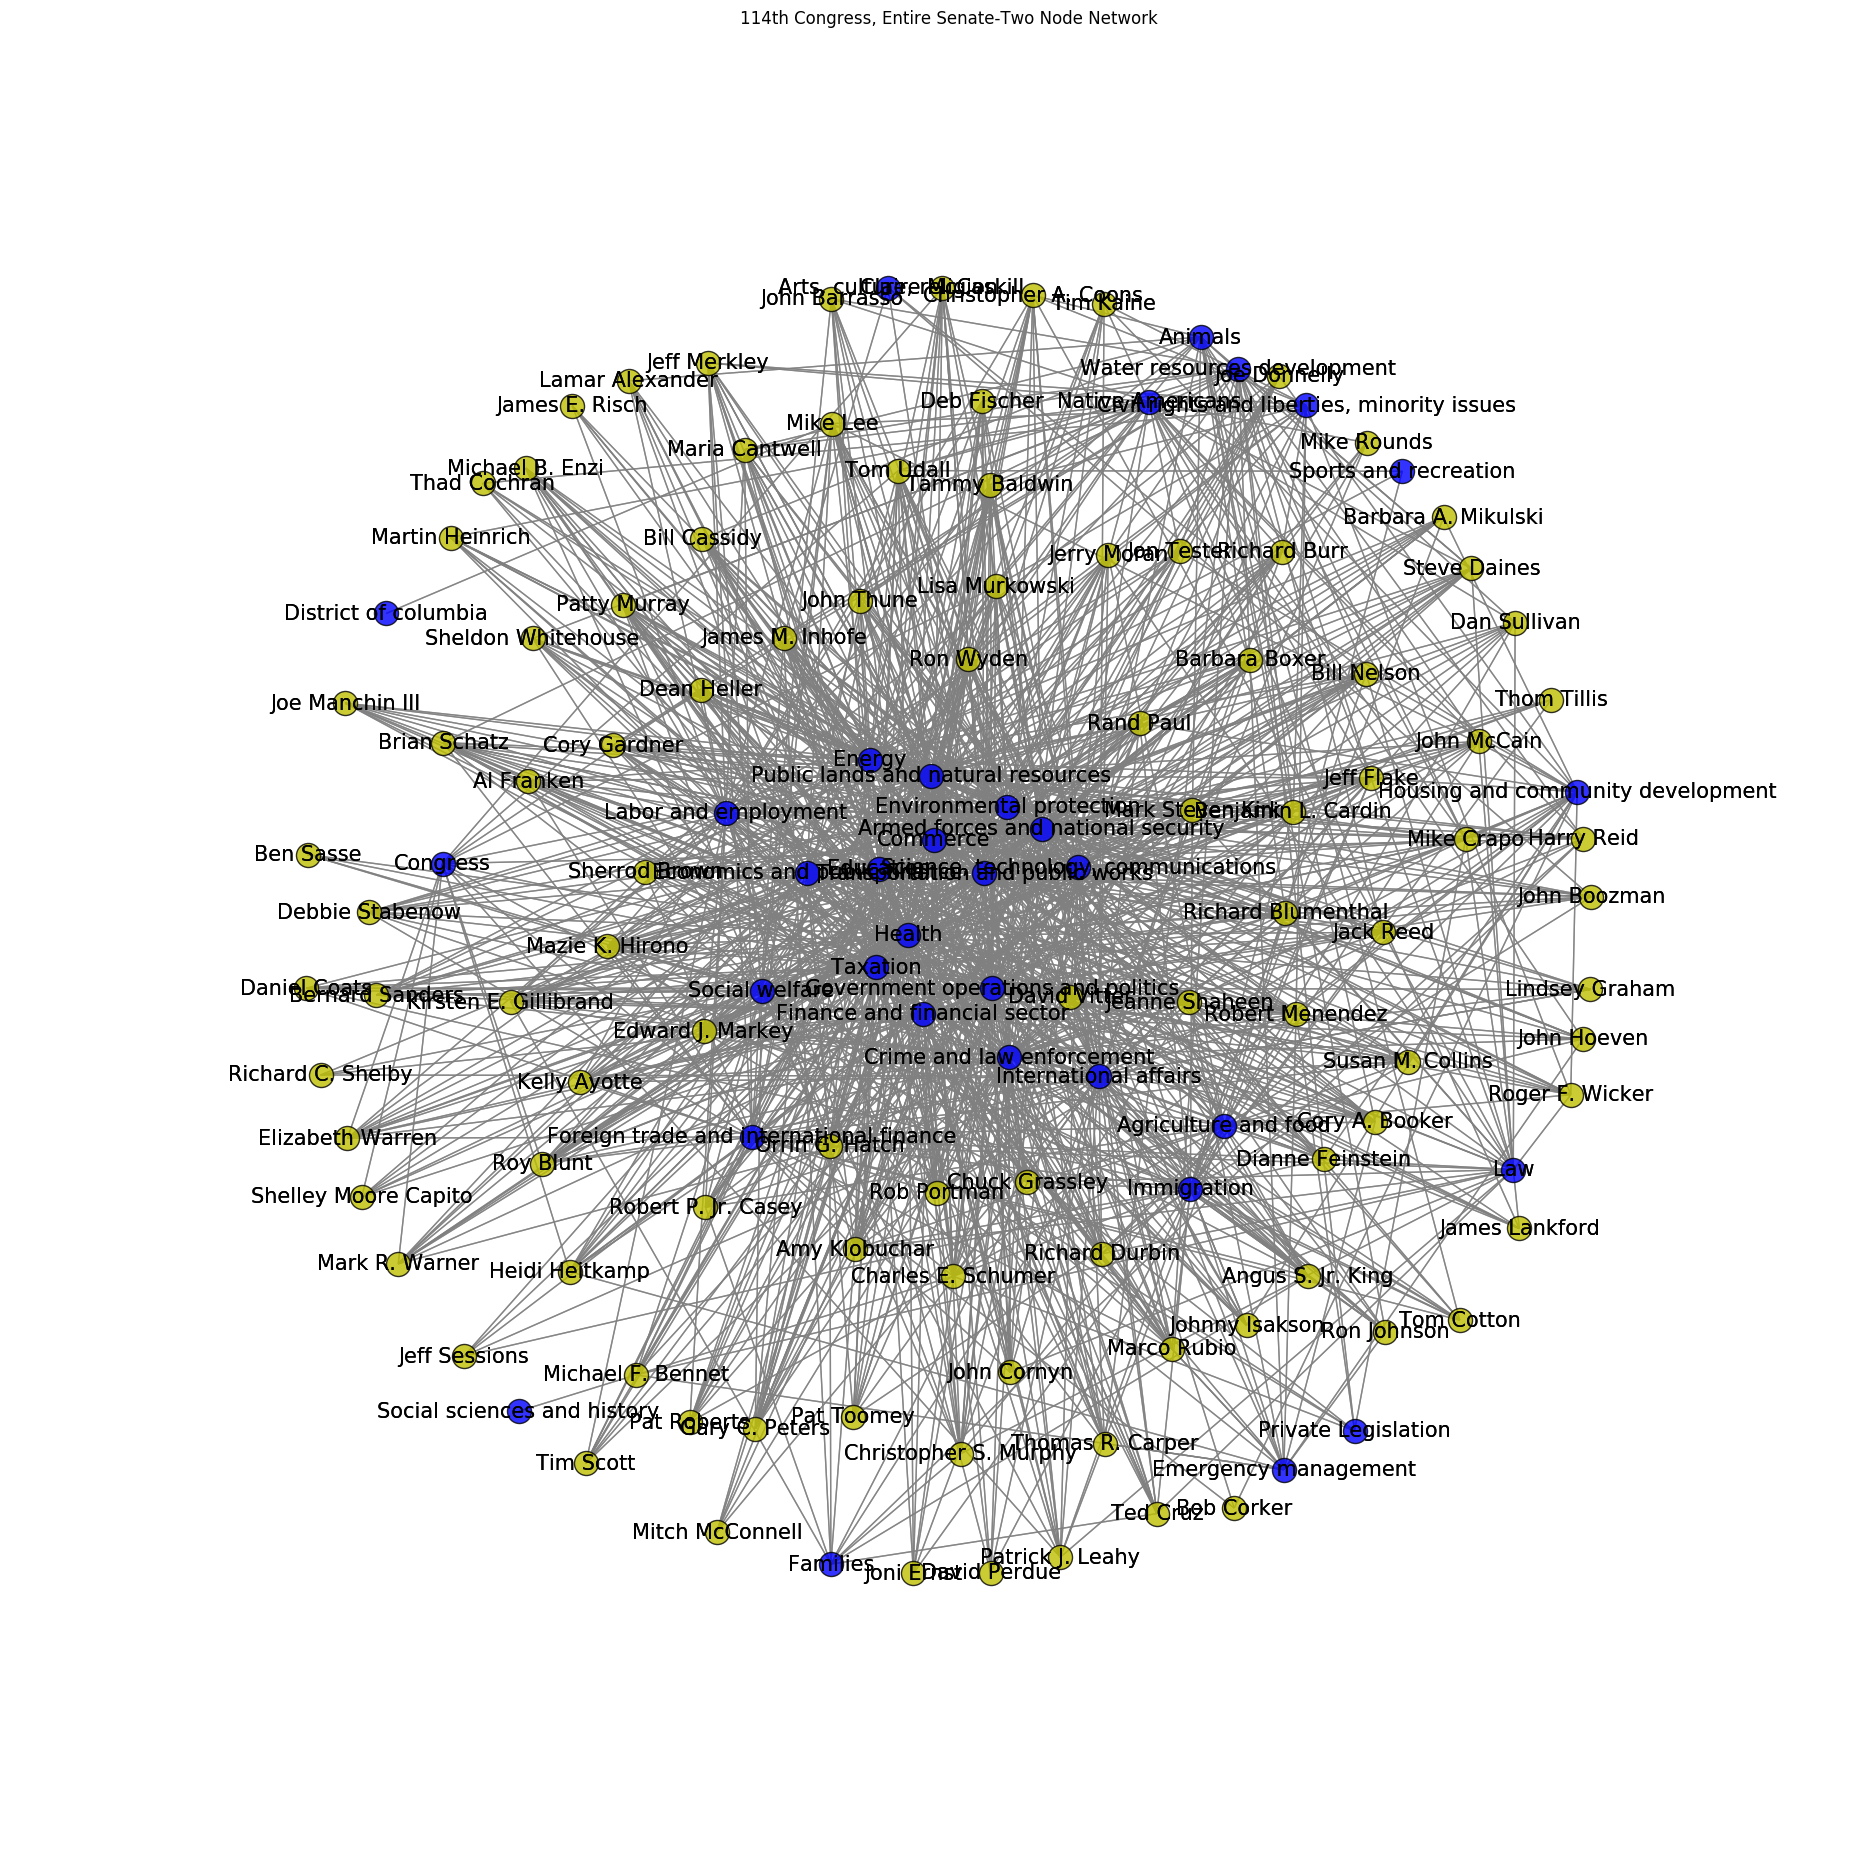

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(18, 18))
B = nx.Graph()
B.add_nodes_from(senatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subjectList, bipartite=1)

for index, row in subjectInfo.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.3, iterations=75)
nx.draw(B, nodelist = senatorsList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(B, nodelist = subjectList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('114th Congress, Entire Senate-Two Node Network')
plt.show()

Get information about node sets. There are 100 Senators and 34 bill subjects.

In [6]:
#Graph can be queried to get information about node sets
top_nodes, bottom_nodes = bipartite.sets(B)

#Total of 100 Senators
print (len(top_nodes))

#Senators
df = pd.DataFrame(list(top_nodes), columns=['Subjects'])
df

34


Subjects
0       Foreign trade and international finance
1                                     Education
2            Government operations and politics
3                                      Commerce
4                      Environmental protection
5                          Emergency management
6                                      Congress
7                  Finance and financial sector
8                   Social sciences and history
9                                   Immigration
10                                     Taxation
11                               Social welfare
12                                       Health
13                 Economics and public finance
14                        International affairs
15              Transportation and public works
16                                     Families
17                        Sports and recreation
18                          Private Legislation
19                         Agriculture and food
20                             Native Americans
21  Civil rights and liberties, minority issues
22                         Labor and employment
23          Science, technology, communications
24           Armed forces and national security
25                    Crime and law enforcement
26                                          Law
27            Housing and community development
28                      Arts, culture, religion
29                                       Energy
30           Public lands and natural resources
31                                      Animals
32                         District of columbia
33                  Water resources development

In [7]:
#Total of 34 Bill Subjects
print (len(bottom_nodes))

#Bill Subjects
df = pd.DataFrame(list(bottom_nodes), columns=['Senators'])
df

100


Senators
0             John Thune
1   Christopher A. Coons
2       Edward J. Markey
3           Daniel Coats
4             Tom Cotton
5          Barbara Boxer
6          Amy Klobuchar
7         Lisa Murkowski
8          Tammy Baldwin
9         Heidi Heitkamp
10           John McCain
11        Richard Durbin
12           Thom Tillis
13        Cory A. Booker
14     Angus S. Jr. King
15     Michael F. Bennet
16             Rand Paul
17       Joe Manchin III
18        James E. Risch
19            Joni Ernst
20          Patty Murray
21      Mark Steven Kirk
22      Elizabeth Warren
23       Mazie K. Hirono
24        Lindsey Graham
25         Jeff Sessions
26              Ted Cruz
27      Thomas R. Carper
28       Debbie Stabenow
29          Kelly Ayotte
..                   ...
70          Bill Cassidy
71    Charles E. Schumer
72           Deb Fischer
73            Pat Toomey
74        Chuck Grassley
75        Orrin G. Hatch
76           Ron Johnson
77          Richard Burr
78          Steve Daines
79     Richard C. Shelby
80       Robert Menendez
81            Jeff Flake
82       Mitch McConnell
83           John Hoeven
84        Jeanne Shaheen
85           Marco Rubio
86             Tim Kaine
87      Susan M. Collins
88          Jeff Merkley
89            Mike Crapo
90          John Boozman
91            Bob Corker
92             Jack Reed
93           Bill Nelson
94             Ben Sasse
95           Jerry Moran
96          Cory Gardner
97        Gary C. Peters
98         John Barrasso
99           John Cornyn

[100 rows x 1 columns]

In [8]:
#Get total number of nodes in the graph (Senators + Bill Subjects)
bipartite.sets(B)
nx.number_of_nodes(B)

134

In [9]:
#Diameter of the graph. Total number of bill presented by Senators during 114th congress.
print(B.size())

1265


In [10]:
#Displays information how nodes are grouped inside the graph
#Senators bipartite value is 1 and bill subject bipartite value is 0
df = pd.DataFrame(list(bipartite.color(B).items()), columns=['Node', 'bipartite'])
df.sort_values(['bipartite', 'Node'], ascending = True, inplace=True)
df

Node  bipartite
132                                   Al Franken          0
14                                 Amy Klobuchar          0
45                             Angus S. Jr. King          0
53                           Barbara A. Mikulski          0
11                                 Barbara Boxer          0
115                                    Ben Sasse          0
13                            Benjamin L. Cardin          0
25                               Bernard Sanders          0
69                                  Bill Cassidy          0
114                                  Bill Nelson          0
111                                   Bob Corker          0
90                                  Brian Schatz          0
70                            Charles E. Schumer          0
6                           Christopher A. Coons          0
96                         Christopher S. Murphy          0
75                                Chuck Grassley          0
77                              Claire McCaskill          0
39                                Cory A. Booker          0
65                                  Cory Gardner          0
101                                 Dan Sullivan          0
9                                   Daniel Coats          0
73                                  David Perdue          0
133                                 David Vitter          0
54                                   Dean Heller          0
52                                   Deb Fischer          0
85                               Debbie Stabenow          0
105                             Dianne Feinstein          0
8                               Edward J. Markey          0
67                              Elizabeth Warren          0
125                               Gary C. Peters          0
..                                           ...        ...
89   Civil rights and liberties, minority issues          1
5                                       Commerce          1
79                                      Congress          1
48                     Crime and law enforcement          1
57                          District of columbia          1
19                  Economics and public finance          1
66                                     Education          1
61                          Emergency management          1
123                                       Energy          1
71                      Environmental protection          1
24                                      Families          1
12                  Finance and financial sector          1
64       Foreign trade and international finance          1
3             Government operations and politics          1
18                                        Health          1
119            Housing and community development          1
86                                   Immigration          1
20                         International affairs          1
99                          Labor and employment          1
49                                           Law          1
33                              Native Americans          1
95                           Private Legislation          1
124           Public lands and natural resources          1
42           Science, technology, communications          1
117                  Social sciences and history          1
87                                Social welfare          1
26                         Sports and recreation          1
0                                       Taxation          1
91               Transportation and public works          1
60                   Water resources development          1

[134 rows x 2 columns]

#Metrics and Inference

###Shortest Path

Function *shortest_path_length* of *NetworkX* library allows us to find the *Shortest Path* from a specific origin to a specified destination in a given network while minimizing the total cost associated with the path. 

In our case, *shortest path* metric shows, bills sponsored by Senator Amy Klobuchar on subjects *Health* and *Science, technology, communications* make it to the floor faster compared to Senator Tom Cotton and Senator Tom Udall.

Example:
Minnesota Democratic Senator Amy Klobuchar has sponsored bills on subjects *Health* and *Science, technology, communications*. She and her staff have more experience than Arkansas Republican Senator Tom Cotton in getting these bills through committees and onto the Senate floor. If people of Arkansas want any legislation introduced related to *Health* and *Science, technology, communications* their chances of getting the bill onto the floor through Senator Amy Klobuchar are very high compared to   Senator Tom Cotton.

In [11]:
#Gives information about average shortest path between Senators and Subjects. 
#Every Senator has at least two subjects common with other Senators.
nx.average_shortest_path_length(B)

2.116934126360678

In [12]:
#Shortest path between Senators and bill subjects
#Value is close to average shortest path.
df = pd.DataFrame(list(bipartite.color(B).items()), columns=['Node', 'bipartite'])
df1 = df[(df.bipartite == 1)]
df2 = df[(df.bipartite == 0)]

cols = ['Subject', 'Senator', 'ShortestPath']
lst = []
for i1, m1 in df1.iterrows():
    for i2, m2 in df2.iterrows():
        s1 = m1[0]
        s2 = m2[0]
        e = False
        if [s1, s2, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if [s2, s1, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if not e:
            lst.append([s1, s2, nx.shortest_path_length(B, s1, s2)])

ShortPath = pd.DataFrame(lst, columns=cols)
ShortPath.sort_values(['ShortestPath', 'Subject', 'Senator'], ascending = True, inplace=True)
ShortPath

Subject                Senator  ShortestPath
910          Agriculture and food          Amy Klobuchar             1
933          Agriculture and food      Angus S. Jr. King             1
969          Agriculture and food  Christopher S. Murphy             1
954          Agriculture and food         Chuck Grassley             1
973          Agriculture and food           Dan Sullivan             1
952          Agriculture and food           David Perdue             1
999          Agriculture and food           David Vitter             1
926          Agriculture and food        James M. Inhofe             1
971          Agriculture and food         Jeanne Shaheen             1
967          Agriculture and food             Jeff Flake             1
990          Agriculture and food            Jerry Moran             1
980          Agriculture and food           John Boozman             1
970          Agriculture and food            John Hoeven             1
976          Agriculture and food  Kirsten E. Gillibrand             1
913          Agriculture and food         Lisa Murkowski             1
902          Agriculture and food               Mike Lee             1
904          Agriculture and food            Pat Roberts             1
931          Agriculture and food       Patrick J. Leahy             1
944          Agriculture and food           Patty Murray             1
968          Agriculture and food     Richard Blumenthal             1
923          Agriculture and food         Richard Durbin             1
966          Agriculture and food        Robert Menendez             1
995          Agriculture and food    Robert P. Jr. Casey             1
941          Agriculture and food        Roger F. Wicker             1
918          Agriculture and food            Ron Johnson             1
974          Agriculture and food       Susan M. Collins             1
961          Agriculture and food              Tom Udall             1
3309                      Animals     Benjamin L. Cardin             1
3349                      Animals           Bill Cassidy             1
3303                      Animals   Christopher A. Coons             1
...                           ...                    ...           ...
1621  Water resources development        Michael B. Enzi             3
1634  Water resources development      Michael F. Bennet             3
1602  Water resources development               Mike Lee             3
1622  Water resources development            Mike Rounds             3
1630  Water resources development        Mitch McConnell             3
1655  Water resources development         Orrin G. Hatch             3
1604  Water resources development            Pat Roberts             3
1653  Water resources development             Pat Toomey             3
1631  Water resources development       Patrick J. Leahy             3
1644  Water resources development           Patty Murray             3
1697  Water resources development              Rand Paul             3
1668  Water resources development     Richard Blumenthal             3
1659  Water resources development           Richard Burr             3
1696  Water resources development      Richard C. Shelby             3
1623  Water resources development         Richard Durbin             3
1632  Water resources development            Rob Portman             3
1666  Water resources development        Robert Menendez             3
1695  Water resources development    Robert P. Jr. Casey             3
1641  Water resources development        Roger F. Wicker             3
1618  Water resources development            Ron Johnson             3
1635  Water resources development              Roy Blunt             3
1614  Water resources development   Shelley Moore Capito             3
1601  Water resources development          Sherrod Brown             3
1674  Water resources development       Susan M. Collins             3
1657  Water resources development               Te

###Node centralities

We will be showing metrics

- Closeness - Closeness is the inverse sum of all shortest paths
- Betweenness - Number of shortest paths that pass through a node
- Degree - The number other nodes that a node is connected to

In our case, *Health* and *Taxation* top the list in all three metrics. In other words, both subjects unite Senators closely than any other subject. Subject *District of Columbia* least popular among Senators.

In [13]:
#Closeness Betweenness Degrees centrality between Senetors and Subjects
close = nx.closeness_centrality(B)
between = nx.betweenness_centrality(B)
degree = nx.degree_centrality(B)
df1 = pd.DataFrame(list(close.items()), columns=['Node', 'Closeness'])
df2 = pd.DataFrame(list(between.items()), columns=['Node', 'Betweenness'])
df3 = pd.DataFrame(list(degree.items()), columns=['Node', 'Degrees'])
df = df1.join(df2.set_index('Node'), on='Node').join(df3.set_index('Node'), on='Node')
df.sort_values(['Closeness', 'Betweenness','Degrees'], ascending = False, inplace=True)
df

Node  Closeness  Betweenness  \
21                                        Health   0.692708     0.101990   
0                                       Taxation   0.651961     0.081904   
126           Public lands and natural resources   0.604545     0.064795   
4             Government operations and politics   0.599099     0.063533   
47            Armed forces and national security   0.588496     0.064645   
49                     Crime and law enforcement   0.545082     0.045923   
92               Transportation and public works   0.545082     0.042655   
68                                     Education   0.527778     0.035685   
133                                 David Vitter   0.523622     0.008982   
23                         International affairs   0.519531     0.046628   
14                  Finance and financial sector   0.515504     0.036473   
72                      Environmental protection   0.515504     0.033388   
17                                 Amy Klobuchar   0.515504     0.006491   
94                                    Jeff Flake   0.511538     0.006419   
100                               Jeanne Shaheen   0.507634     0.006398   
9                                 Orrin G. Hatch   0.507634     0.005318   
71                            Charles E. Schumer   0.503788     0.021357   
5                                       Mike Lee   0.503788     0.019391   
15                                     Tom Udall   0.503788     0.009767   
95                            Richard Blumenthal   0.503788     0.009606   
93                               Robert Menendez   0.503788     0.006964   
39                                     Ron Wyden   0.503788     0.005168   
35                                Richard Durbin   0.503788     0.004653   
45                                   Rob Portman   0.503788     0.004406   
64                              Mark Steven Kirk   0.503788     0.004089   
38                               James M. Inhofe   0.500000     0.008501   
116                                  Bill Nelson   0.500000     0.007933   
109                                   Mike Crapo   0.500000     0.006094   
107                             Dianne Feinstein   0.500000     0.005646   
81                                   Marco Rubio   0.500000     0.004304   
..                                           ...        ...          ...   
31                               Lamar Alexander   0.458621     0.000788   
67                          Shelley Moore Capito   0.458621     0.000670   
120                                 Thad Cochran   0.458621     0.000557   
42                               Mitch McConnell   0.458621     0.000255   
77                                 Jeff Sessions   0.449324     0.000474   
117                                    Ben Sasse   0.449324     0.000134   
22                  Economics and public finance   0.446309     0.015759   
33                                   Mike Rounds   0.446309     0.000284   
74                             Richard C. Shelby   0.446309     0.000151   
87                                   Immigration   0.443333     0.015822   
88                                Social welfare   0.443333     0.014690   
65       Foreign trade and international finance   0.437500     0.015152   
36                                   Thom Tillis   0.437500     0.000262   
56                                James E. Risch   0.437500     0.000176   
29                          Agriculture and food   0.423567     0.008114   
34                              Native Americans   0.420886     0.008903   
50                                           Law   0.418239     0.006880   
121            Housing and community development   0.413043     0.007747   
61                   Water resources development   0.407975     0.004550   
130                                      Animals   0.398204     0.003565   
80                                      Congress   0.393491     0.002552   
89   Civil right

###Projection

According to the article published by Tore Opsahl, on https://toreopsahl.com/tnet/two-mode-networks/, *Projection* is described as *transforming a two-mode network into a one-mode network*. The process works by selecting one set of nodes and linking two nodes if they are connected to the same node of the other set.

Following is the projected graph of Senators.

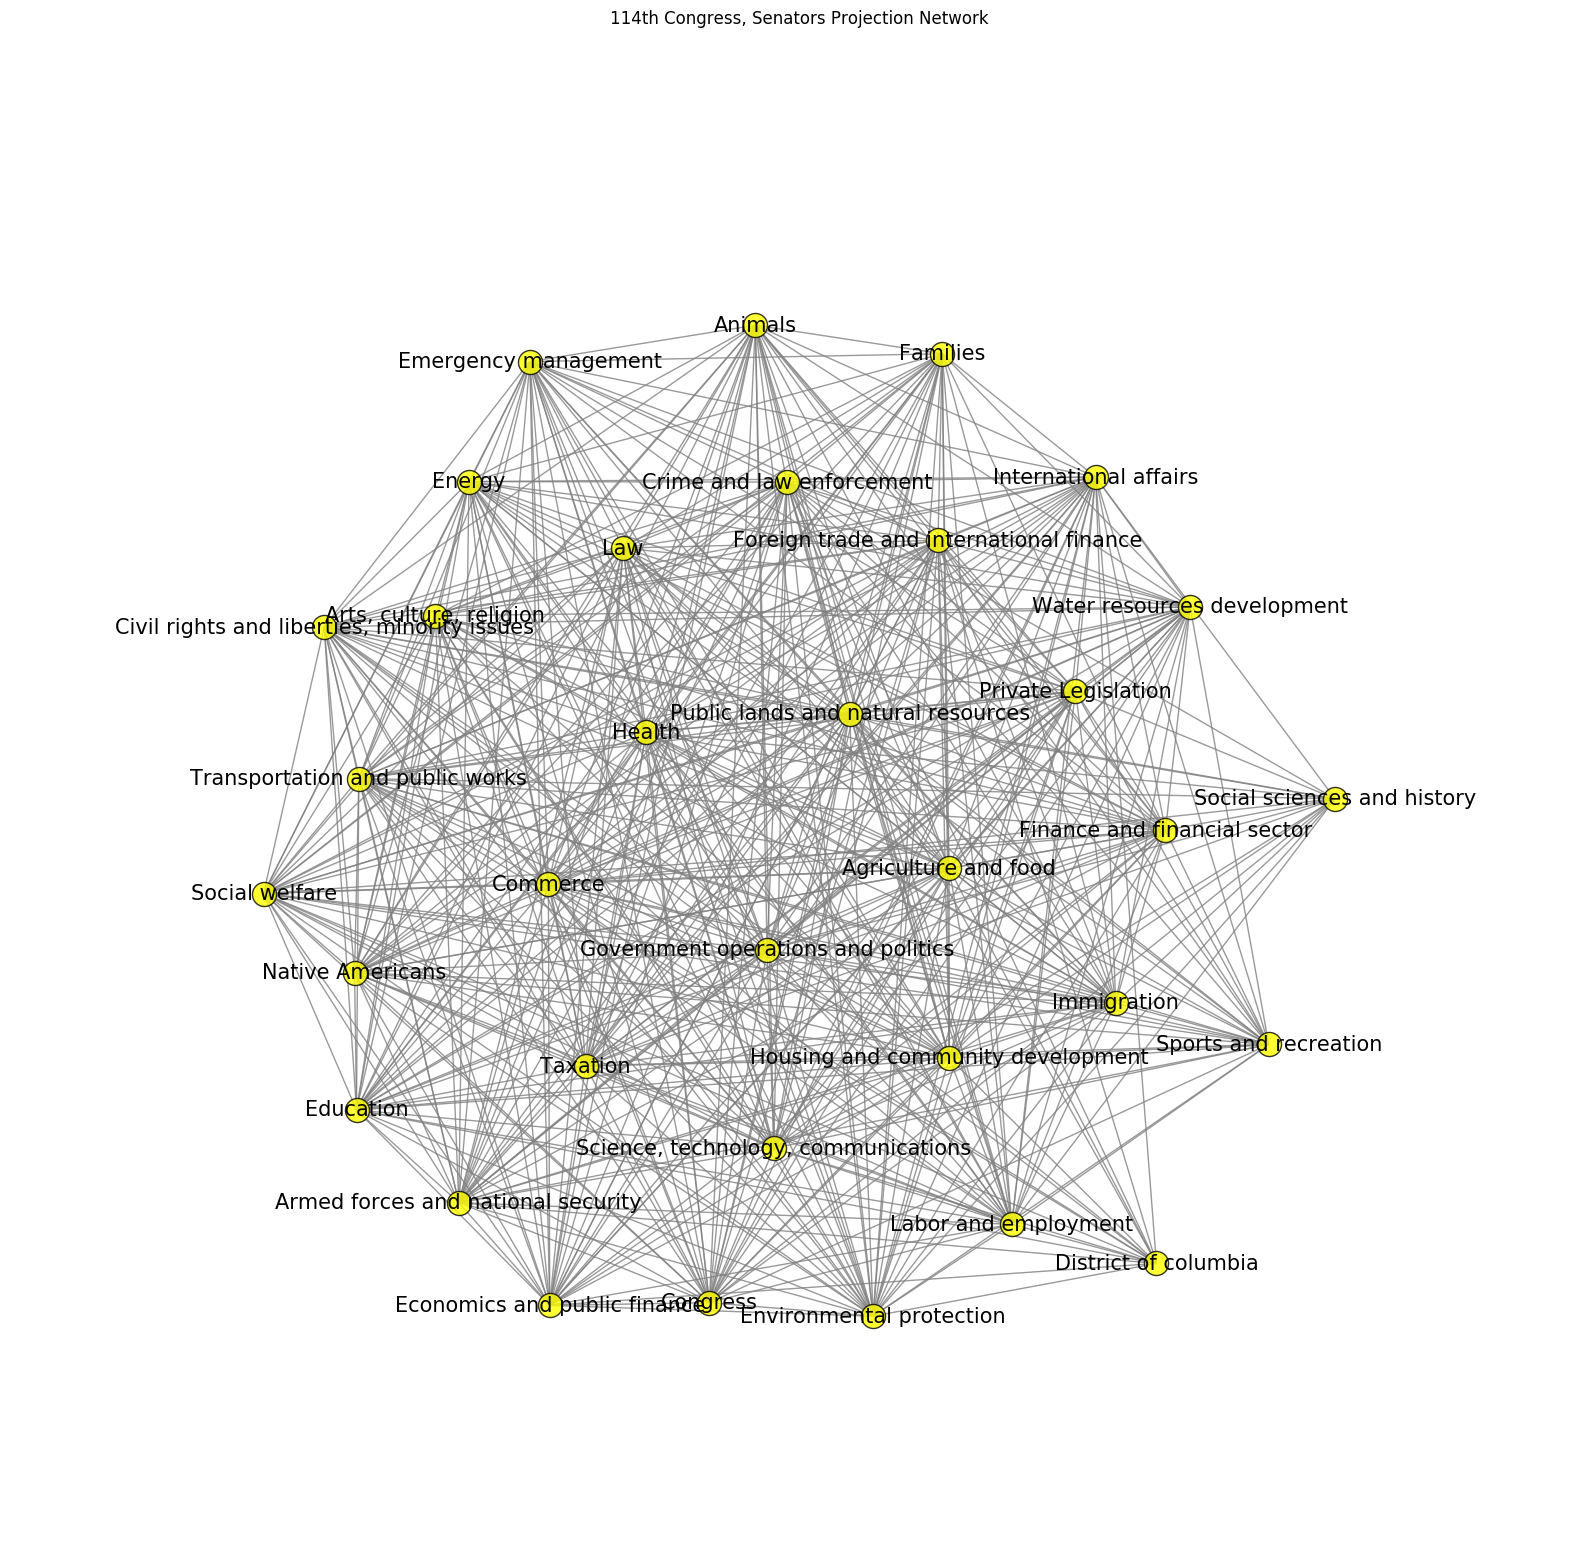

In [14]:
#Graph shows Senators are tightly connected.
G = bipartite.projected_graph(B, top_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.6, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'yellow')
plt.title('114th Congress, Senators Projection Network')
plt.show()

Following network is projected graph of bill subjects. 

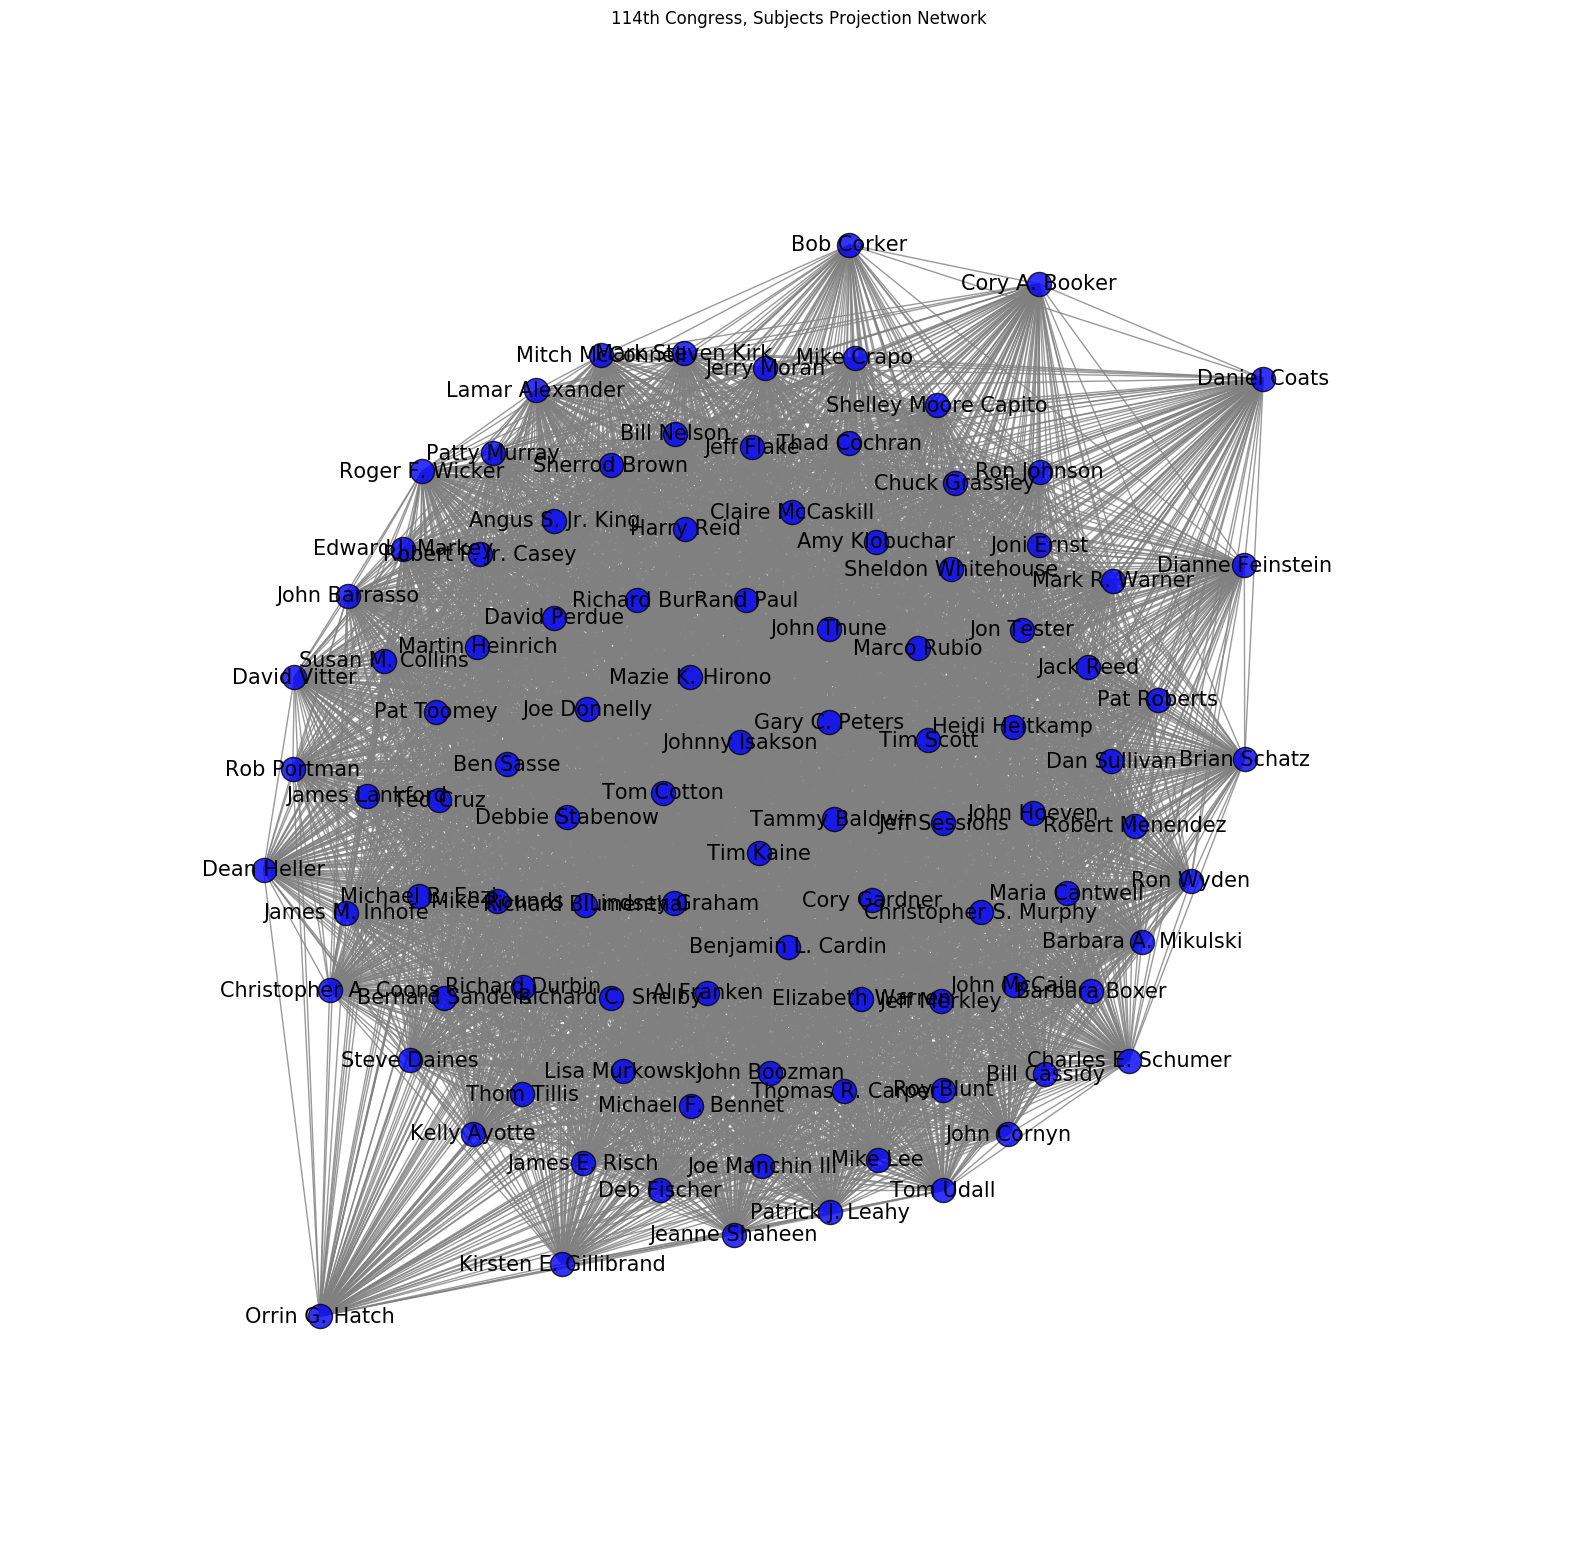

In [15]:
#Graph shows they are connected to the most part.
#Not all subjects are linked. Example: Social sciences & history and District of Columbia
#They were least popular among Senators

G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.5, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b')
plt.title('114th Congress, Subjects Projection Network')
plt.show()

###Density

A Dense graph is a graph in which the number of edges is close to the maximal number of edges. Following shows nodes in each node-set are evenly dense. Output suggests it is not a dense graph.

In [16]:
#Density
print(bipartite.density(B,top_nodes))

print(bipartite.density(B,bottom_nodes))

0.3720588235294118
0.3720588235294118


###Clustering

Two-mode clustering metrics show there is a high level of clustering around Senators Gary C. Peters, Senator Edward J. Markey and Senator Amy Klobuchar. In other words Senators are creating clusters around subjects. We can assume that Senators are more actively working on subjects.

In [17]:
c = bipartite.clustering(B)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Clustering'])
df.sort_values(['Clustering', 'Node'], ascending = False, inplace=True)
df

Node  Clustering
127                               Gary C. Peters    0.467979
10                              Edward J. Markey    0.466050
17                                 Amy Klobuchar    0.465132
45                                   Rob Portman    0.458394
64                              Mark Steven Kirk    0.457735
63                                  Patty Murray    0.449602
24                                 Tammy Baldwin    0.443799
91                                  Brian Schatz    0.443223
9                                 Orrin G. Hatch    0.438549
97                                     Roy Blunt    0.433688
13                                 Barbara Boxer    0.429799
90                                   Dean Heller    0.428701
39                                     Ron Wyden    0.428436
124                                 Kelly Ayotte    0.427624
35                                Richard Durbin    0.424544
106                        Kirsten E. Gillibrand    0.424226
114                                  John Cornyn    0.423339
133                                 David Vitter    0.422189
100                               Jeanne Shaheen    0.421120
84                               Michael B. Enzi    0.416889
70                                  Bill Cassidy    0.415656
132                                 Cory Gardner    0.414451
122                                  Jerry Moran    0.406920
40                                Cory A. Booker    0.406413
30                                    John Thune    0.406024
27                               Bernard Sanders    0.404171
81                                   Marco Rubio    0.402996
2                          Christopher S. Murphy    0.402861
129                           Sheldon Whitehouse    0.398786
94                                    Jeff Flake    0.398304
..                                           ...         ...
1                                 James Lankford    0.248444
37                                    Harry Reid    0.244810
98                                  David Perdue    0.236183
120                                 Thad Cochran    0.228641
22                  Economics and public finance    0.218295
88                                Social welfare    0.214168
87                                   Immigration    0.211763
50                                           Law    0.207037
29                          Agriculture and food    0.205080
56                                James E. Risch    0.201195
65       Foreign trade and international finance    0.200920
33                                   Mike Rounds    0.189306
117                                    Ben Sasse    0.185288
34                              Native Americans    0.174577
61                   Water resources development    0.169541
121            Housing and community development    0.167055
36                                   Thom Tillis    0.165161
74                             Richard C. Shelby    0.164930
77                                 Jeff Sessions    0.153204
130                                      Animals    0.148732
112                         Emergency management    0.145375
89   Civil rights and liberties, minority issues    0.126924
80                                      Congress    0.118515
26                                      Families    0.118401
113                                   Bob Corker    0.101726
96                           Private Legislation    0.082698
123                      Arts, culture, religion    0.053245
28                         Sports and recreation    0.042717
119                  Social sciences and history    0.032616
58                          District of columbia    0.025329

[134 rows x 2 columns]

###Local clustering coefficient for two-mode networks

Clustering values obtained using *Robins Alexander method* and *Global Average Method* differ because *Robins Alexander method* clustering coefficients for two-mode networks are based on 4-cycles, which is the smallest possible cycle in two-mode networks. Robins and Alexander defined a coefficient as the ratio between the number of 4-cycles and the number of 3-paths.

Whereas *Global Average Method* uses one-mode clustering coefficient to detect closure among three nodes. Hence the difference in values.

Reference: https://toreopsahl.com/tnet/two-mode-networks/clustering/

In [18]:
#Average clustering Robins Alexander method
print(round(bipartite.robins_alexander_clustering(B), 3))

#Average clustering
print(round(bipartite.average_clustering(B), 3))

0.552
0.316


###Subgroups

This occurrence of situations in which the nodes of a graph fall into two or more groups with some nodes acting as links between the groups. Following table shows subgroup formation between two different node sets.

In [19]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3
a = get_triangles(B)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1                  node2  \
0      Social welfare  Sports and recreation   
1      Social welfare               Taxation   
2      Social welfare               Taxation   
3      Social welfare               Taxation   
4      James Lankford          Sherrod Brown   
5      James Lankford          Sherrod Brown   
6      James Lankford             John Thune   
7      James Lankford             John Thune   
8      James Lankford             John Thune   
9      James Lankford               Mike Lee   
10     James Lankford            Pat Roberts   
11     James Lankford            Pat Roberts   
12     James Lankford              Tom Udall   
13     James Lankford             Jon Tester   
14     James Lankford             Jon Tester   
15     James Lankford         Lisa Murkowski   
16     James Lankford         Lisa Murkowski   
17     James Lankford         Lisa Murkowski   
18     James Lankford          Tammy Baldwin   
19     James Lankford          Tammy Baldwin   
20     James Lankford        Lamar Alexander   
21     James Lankford        Michael B. Enzi   
22     James Lankford        Michael B. Enzi   
23     James Lankford         Richard Durbin   
24     James Lankford        James M. Inhofe   
25     James Lankford        James M. Inhofe   
26     James Lankford        James M. Inhofe   
27     James Lankford              Ron Wyden   
28     James Lankford              Ron Wyden   
29     James Lankford         Maria Cantwell   
...               ...                    ...   
12902     John Cornyn              Roy Blunt   
12903     John Cornyn        Mitch McConnell   
12904     John Cornyn            John Hoeven   
12905     John Cornyn            Marco Rubio   
12906     John Cornyn            Marco Rubio   
12907     John Cornyn            Marco Rubio   
12908     John Cornyn            Marco Rubio   
12909     John Cornyn            Thom Tillis   
12910     John Cornyn       Susan M. Collins   
12911     John Cornyn  Kirsten E. Gillibrand   
12912     John Cornyn  Kirsten E. Gillibrand   
12913     John Cornyn  Kirsten E. Gillibrand   
12914     John Cornyn             Mike Crapo   
12915     John Cornyn             Mike Crapo   
12916     John Cornyn             Mike Crapo   
12917     John Cornyn        Martin Heinrich   
12918     John Cornyn        Martin Heinrich   
12919     John Cornyn        Martin Heinrich   
12920     John Cornyn         Mark R. Warner   
12921     John Cornyn         Mark R. Warner   
12922     John Cornyn         Mark R. Warner   
12923     John Cornyn           Thad Cochran   
12924     John Cornyn           Kelly Ayotte   
12925     John Cornyn           Kelly Ayotte   
12926     John Cornyn           Kelly Ayotte   
12927     John Cornyn           Kelly Ayotte   
12928     John Cornyn     Sheldon Whitehouse   
12929     John Cornyn     Sheldon Whitehouse   
12930     John Cornyn    Robert P. Jr. Casey   
12931     John Cornyn    Robert P. Jr. Casey   

                                     node3  
0                                Tom Udall  
1                               Tom Cotton  
2                         Thomas R. Carper  
3                                Tom Udall  
4          Transportation and public works  
5                                 Taxation  
6                         Native Americans  
7                                 Taxation  
8          Transportation and public works  
9          Transportation and public works  
10         Transportation and public works  
11                                Taxation  
12         Transportation and public works  
13                        Native Americans  
14                                Taxation  
15                        Native Americans  
16                                Taxation  
17         Transportation and public works  
18         Transportation and public works  
19                                Taxation  
20                                Taxation  
21                                Taxation  
22  

###Cliques

A clique is defined as a maximal complete subgraph of a given graph. Example: a group of nodes where every node is connected directly to every other node. The word *maximal* means that no other nodes can be added to the clique without making it less connected.

When the entire two-node graph is checked for cliques, bill subjects *Health* and *Taxation* ranked on the top. This explains Senator connecting to these bill subjects make a complete subgraph or a clique.

Bill subjects *Health* and *Taxation* connect more Senators, creating more cliques.

In [20]:
c = nx.number_of_cliques(B)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
21                                    Health       88
0                                   Taxation       82
126       Public lands and natural resources       73
4         Government operations and politics       72
47        Armed forces and national security       71
92           Transportation and public works       61
49                 Crime and law enforcement       61
68                                 Education       58
23                     International affairs       55
14              Finance and financial sector       55
72                  Environmental protection       54
125                                   Energy       51
6                                   Commerce       45
101                     Labor and employment       44
43       Science, technology, communications       42
22              Economics and public finance       36
88                            Social welfare       34
87                               Immigration       34
65   Foreign trade and international finance       32
34                          Native Americans       27
29                      Agriculture and food       27
50                                       Law       26
133                             David Vitter       23
61               Water resources development       22
121        Housing and community development       22
17                             Amy Klobuchar       21
94                                Jeff Flake       20
9                             Orrin G. Hatch       19
100                           Jeanne Shaheen       19
130                                  Animals       19
..                                       ...      ...
52                           Joe Manchin III       10
59                              Joe Donnelly       10
54                       Barbara A. Mikulski       10
55                                Al Franken       10
12                                Tom Cotton        9
102                                Tim Kaine        9
111                          Martin Heinrich        9
19                                 Tim Scott        8
48                         Michael F. Bennet        8
76                            Lindsey Graham        8
31                           Lamar Alexander        8
11                              Daniel Coats        8
67                      Shelley Moore Capito        7
96                       Private Legislation        7
60                                Joni Ernst        7
1                             James Lankford        7
98                              David Perdue        7
120                             Thad Cochran        6
42                           Mitch McConnell        6
36                               Thom Tillis        5
33                               Mike Rounds        5
77                             Jeff Sessions        5
56                            James E. Risch        5
74                         Richard C. Shelby        4
117                                Ben Sasse        4
123                  Arts, culture, religion        4
28                     Sports and recreation        3
113                               Bob Corker        3
119              Social sciences and history        1
58                      District of columbia        1

[134 rows x 2 columns]

However on a projected graph, bill subject *Transportation and public works* stand out. That means this subject is more popular among Senators.

In [31]:
G = bipartite.projected_graph(B, top_nodes, multigraph=False)
c = nx.number_of_cliques(G)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
29              Transportation and public works        6
10          Science, technology, communications        6
24           Public lands and natural resources        6
28                        International affairs        6
18            Housing and community development        6
19           Government operations and politics        6
8                      Environmental protection        6
16                    Crime and law enforcement        6
7                                      Commerce        6
22                                     Taxation        5
3                                Social welfare        5
6                          Labor and employment        5
20                                  Immigration        5
26                                       Health        5
2       Foreign trade and international finance        5
14                 Finance and financial sector        5
5                                     Education        5
11                                     Congress        5
15           Armed forces and national security        5
1                          Agriculture and food        5
32                  Water resources development        4
4                              Native Americans        4
12                                          Law        4
23                                       Energy        4
33                 Economics and public finance        4
0                           Private Legislation        3
25  Civil rights and liberties, minority issues        3
27                                      Animals        3
13                                     Families        2
9                          Emergency management        2
31                        Sports and recreation        1
17                  Social sciences and history        1
30                         District of columbia        1
21                      Arts, culture, religion        1

On a projected graph, following table, shows subgroups among bill subjects. That means these subjects are more popular among Senators and bills connected to these subjects tend to make it floor more often.

In [33]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3

a = get_triangles(G)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1                                node2  \
0       Private Legislation                             Taxation   
1       Private Legislation                             Taxation   
2       Private Legislation  Science, technology, communications   
3       Private Legislation  Science, technology, communications   
4       Private Legislation  Science, technology, communications   
5       Private Legislation  Science, technology, communications   
6       Private Legislation  Science, technology, communications   
7       Private Legislation  Science, technology, communications   
8       Private Legislation          Social sciences and history   
9       Private Legislation          Social sciences and history   
10      Private Legislation                       Social welfare   
11      Private Legislation                       Social welfare   
12      Private Legislation                       Social welfare   
13      Private Legislation                       Social welfare   
14      Private Legislation   Public lands and natural resources   
15      Private Legislation   Public lands and natural resources   
16      Private Legislation   Public lands and natural resources   
17      Private Legislation   Public lands and natural resources   
18      Private Legislation   Public lands and natural resources   
19      Private Legislation   Public lands and natural resources   
20      Private Legislation   Public lands and natural resources   
21      Private Legislation      Transportation and public works   
22      Private Legislation                Sports and recreation   
23      Private Legislation                Sports and recreation   
24      Private Legislation                Sports and recreation   
25     Agriculture and food                  Private Legislation   
26     Agriculture and food                  Private Legislation   
27     Agriculture and food                  Private Legislation   
28     Agriculture and food                  Private Legislation   
29     Agriculture and food                  Private Legislation   
...                     ...                                  ...   
5115               Families   Public lands and natural resources   
5116               Families   Public lands and natural resources   
5117               Families                               Health   
5118               Families                               Health   
5119               Families                               Health   
5120               Families                               Health   
5121               Families                               Health   
5122               Families                               Health   
5123               Families                               Health   
5124               Families                               Health   
5125               Families                               Health   
5126               Families                               Health   
5127               Families                               Health   
5128               Families                               Health   
5129               Families                International affairs   
5130               Families                International affairs   
5131               Families                International affairs   
5132               Families                International affairs   
5133               Families                International affairs   
5134               Families                International affairs   
5135               Families                International affairs   
5136               Families                International affairs   
5137               Families                International affairs   
5138               Families      Transportation and public works   
5139               Families                Sports and recreation   
5140               Families                Sports and recreation   
5141               Families                Sports and recreation   
5142  Spor

###Final Analysis

- Senators presenting most bills
- Subjects on which most bills are presented.

We will be using *island method* from chapter 4 of *Social Network Analysis for Startups*

In [23]:
def trim_edges(g, weight=1):
        g2=nx.Graph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] > weight:
                        g2.add_edge(f,to,edata)
        return g2
        
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations    
    step=int((mx-mn)/iterations)    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]
    
cc = max(nx.connected_component_subgraphs(B), key=len)
islands=island_method(cc)

Analysis: 

- When every Senator presents one bill on any of 34 subjects; network separates into 129 nodes and 129 islands.
- When the water level is raised 6 units, meaning removing Senators from the network who present less than 6 bills, network separates into 73 nodes and 73 islands.
- When the water level is raised 11 units, meaning removing Senators from the network who present less than 11 bills, network separates into 21 nodes and 3 islands. The first island has 7 nodes, the second island has 6 nodes and third has 8 nodes.
- When the water level is raised 21 units, meaning removing Senators from the network who present less than 21 bills, network separates into 4 nodes and 2 islands. Both islands have 2 nodes each.
- When the water level is raised the highest possible level, meaning removing Senators from the network who present less than 26 bills, network separates into 2 nodes and single island. This combination represents Senator presenting most bills and popular subject.


In [24]:
print ('%-25s %-45s %-13s' % ('Number of Bills', 'Nodes(Senetors + Subjects)', 'Islands'))
for i in islands:
    print ('%-25s %-45s %-13s' % (i[0], len(i[1]), [len(c) for c in nx.connected_component_subgraphs(i[1])]))

Number of Bills           Nodes(Senetors + Subjects)                    Islands      
1                         129                                           [129]        
6                         73                                            [73]         
11                        21                                            [6, 8, 7]    
16                        8                                             [3, 3, 2]    
21                        4                                             [2, 2]       
26                        2                                             [2]          


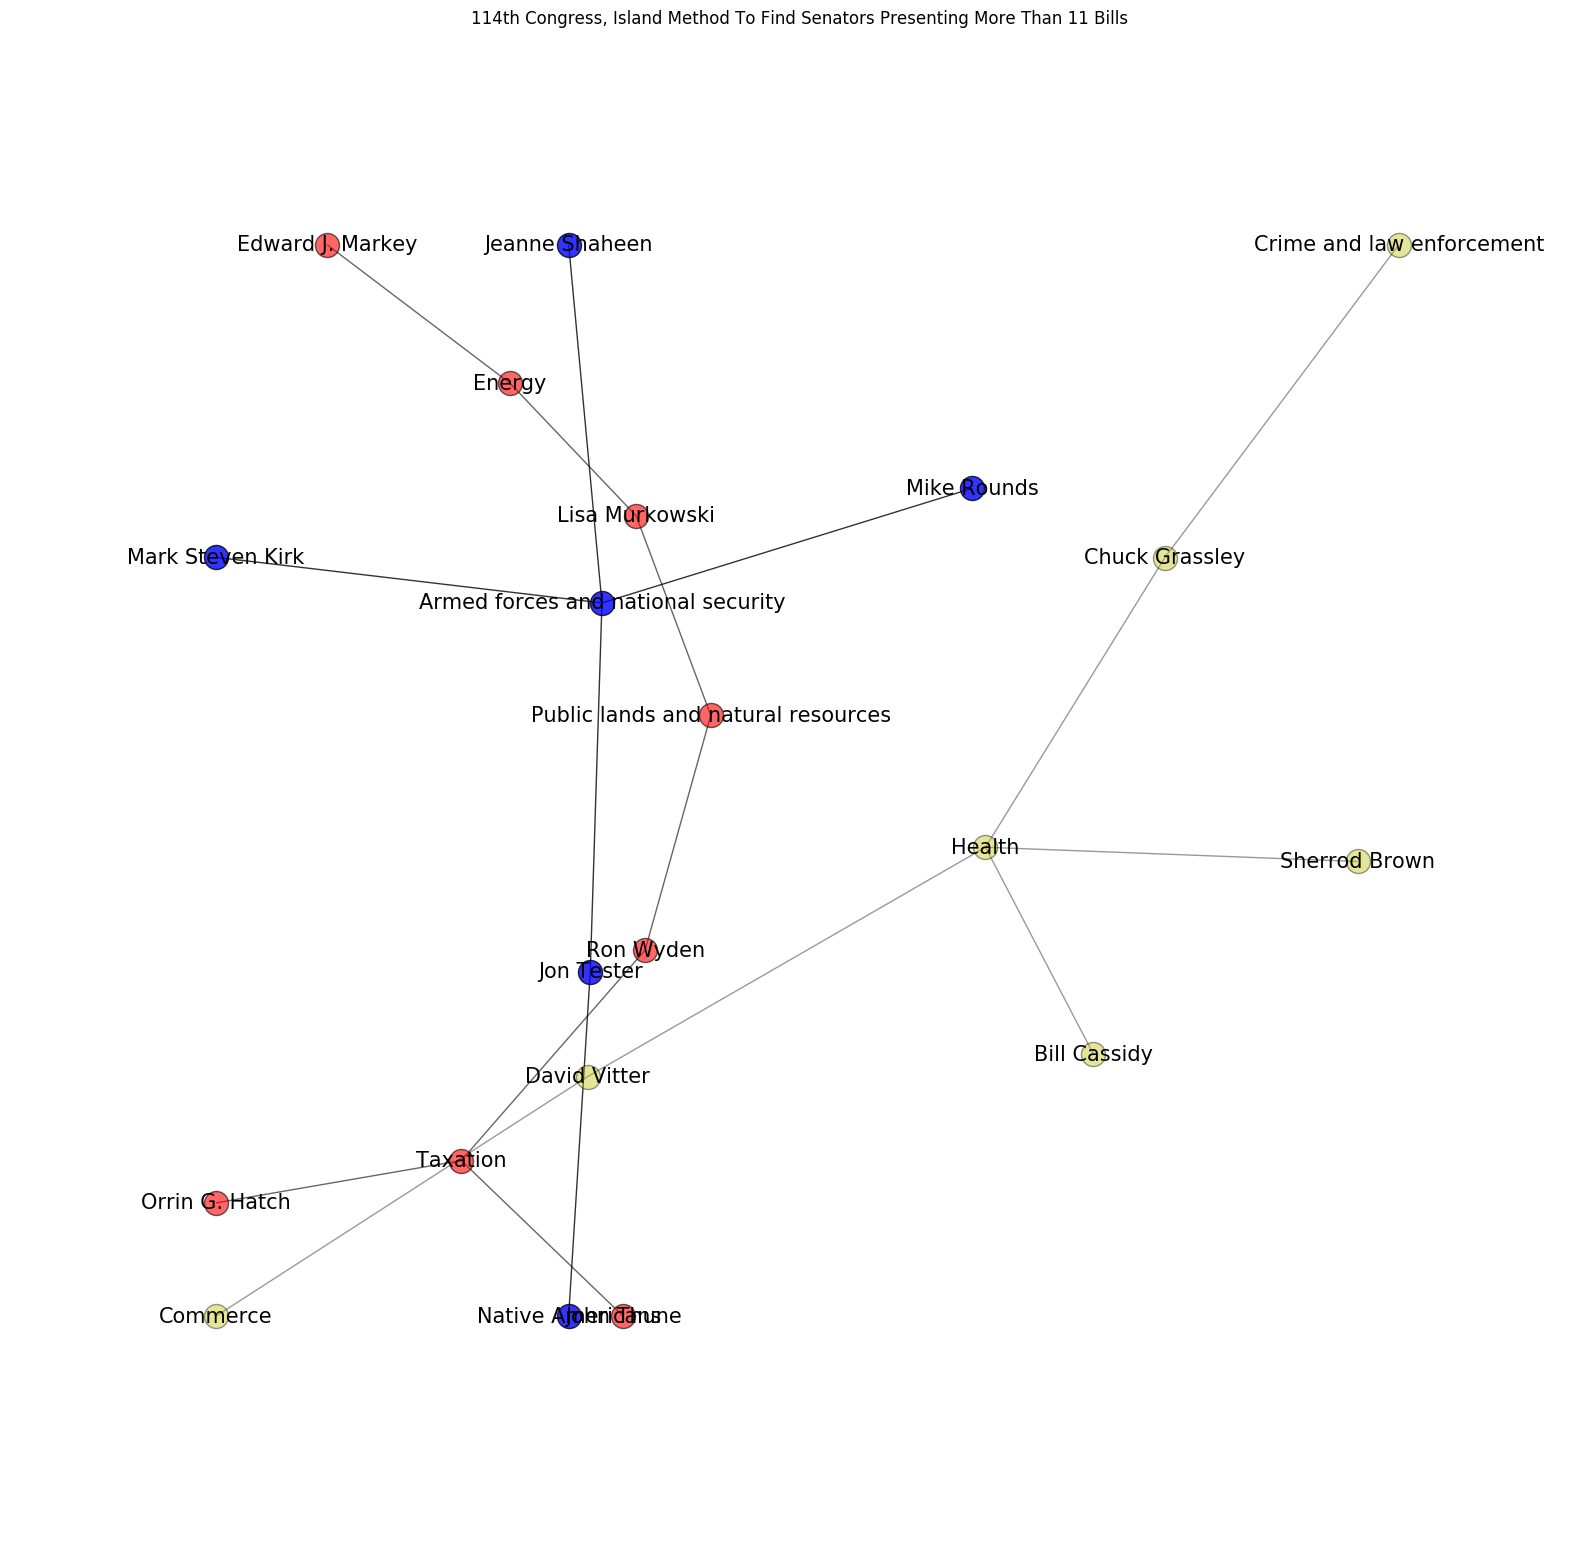

In [35]:
#Colors represent 3 different islands
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(15, 15))

for i in islands:
    if i[0] == 11:
        j = 0
        for c in nx.connected_component_subgraphs(i[1]):
            if j == 0:
                nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'b')
            if j == 1:
                nx.draw(c, with_labels=True, font_size=15, alpha=.6, node_color = 'r')
            if j == 2:
                nx.draw(c, with_labels=True, font_size=15, alpha=.4, node_color = 'y')
            j = j + 1
            
plt.title('114th Congress, Island Method To Find Senators Presenting More Than 11 Bills')
plt.show()


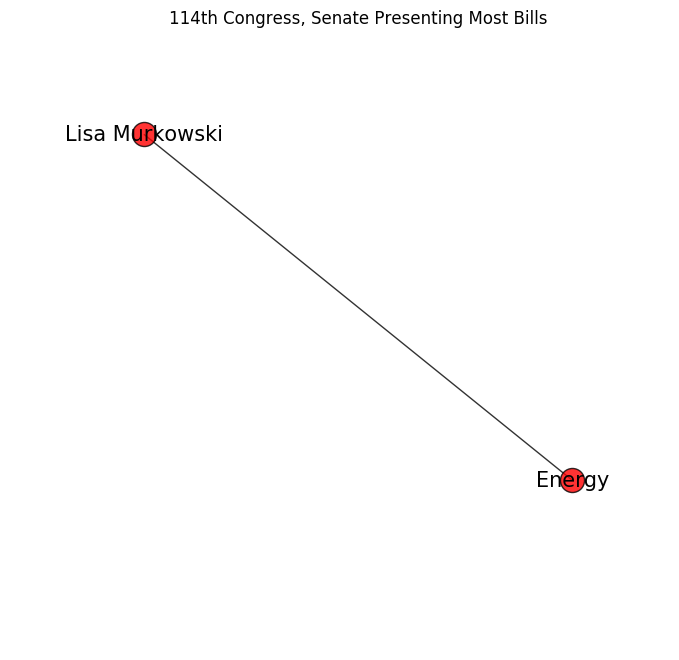

In [36]:
#Senetor presenting most bills on popular subject
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(6, 6))

for i in islands:
    if i[0] == 26:
        for c in nx.connected_component_subgraphs(i[1]):
            nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'r')
            
plt.title('114th Congress, Senate Presenting Most Bills')
plt.show()